#DATASCI W261: Machine Learning at Scale 

* **Sayantan Satpati**
* **sayantan.satpati@ischool.berkeley.edu**
* **W261**
* **Week-7**
* **Assignment-7**
* **Date of Submission: 27-OCT-2015**

#  === Week 9: Page Rank ===

### First BASE Version [Before HW9 was published]

In [21]:
%%writefile mrjob_hw90.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast

'''
Sample Input Data:
1	0.2,[2,4]
2	0.2,[3,5]
3	0.2,[4]
4	0.2,[5]
5	0.2,[1,2,3]
'''

class PageRank(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer)
        ]
    

    def mapper(self, key, value):
        value = value.strip().replace("\"","")
        t = value.split("|")
        
        #sys.stderr.write('[M] {0} | {1} | {2}\n'.format(key, t[0], t[1]))
        
        node = key
        score = t[0]
        neighbors = ast.literal_eval(t[1])
        
        # Emit the Graph Structure
        yield int(node), ('NODE', value)
        
        # Emit the mass
        for n in neighbors:
            yield n, ('SCORE', float(score)/len(neighbors))
                   
        #self.increment_counter('page_rank', 'dangling_node', amount=1)
            
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):
        prev_score = None
        adj_list = None
        total_score = 0

        for value_type, value in values:
            #sys.stderr.write('[R1] {0} | {1} | {2}\n'.format(key, value_type, value))
            if value_type == 'NODE':
                t = value.strip().split("|")
                prev_score = t[0]
                adj_list = t[1]
            else:
                assert value_type == 'SCORE'
                total_score += value
        
        '''
        node['prev_score'] = node['score']

        d = self.options.damping_factor
        node['score'] = 1 - d + d * total_score
        '''

        #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
        yield key, '{0}|{1}'.format(total_score, adj_list)

   
if __name__ == '__main__':
    PageRank.run()

Overwriting mrjob_hw90.py


In [22]:
!chmod a+x mrjob_hw90.py

In [23]:
# Run Once
!python mrjob_hw90.py pr.txt

using configs in /Users/ssatpati/.mrjob.conf
creating tmp directory /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151029.205324.659854

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151029.205324.659854/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151029.205324.659854/step-0-mapper-sorted
> sort /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151029.205324.659854/step-0-mapper_part-00000
writing to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_hw90.ssatpati.20151029.205324.659854/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
M

In [27]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw90 import PageRank
import pprint

input_file = 'pr.txt'
input_file_iter = input_file + '1'

cnt = 0

# After so many iterations (TBD: Convergence Criteria)
while cnt < 5:
    print "\n\nIteration: " + str(cnt+1) + ":"
    if cnt == 0:
        mr_job = PageRank(args=[input_file,
                                '--no-strict-protocol'])
    else:
        mr_job = PageRank(args=[input_file_iter,
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()

        with open(input_file_iter, 'w') as f:
            for line in runner.stream_output():
                parsed_line = mr_job.parse_output_line(line)
                print parsed_line
                f.write(line)
                
    cnt += 1

    #print "# MR Counters:"
    #pprint.pprint(runner.counters()[0])



Iteration: 1:
(1, '0.0666666666667|[2,4]')
(2, '0.166666666667|[3,5]')
(3, '0.166666666667|[4]')
(4, '0.3|[5]')
(5, '0.3|[1,2,3]')


Iteration: 2:
(1, '0.1|[2,4]')
(2, '0.133333333333|[3,5]')
(3, '0.183333333333|[4]')
(4, '0.2|[5]')
(5, '0.383333333334|[1,2,3]')


Iteration: 3:
(1, '0.127777777778|[2,4]')
(2, '0.177777777778|[3,5]')
(3, '0.194444444444|[4]')
(4, '0.233333333333|[5]')
(5, '0.266666666667|[1,2,3]')


Iteration: 4:
(1, '0.088888888889|[2,4]')
(2, '0.152777777778|[3,5]')
(3, '0.177777777778|[4]')
(4, '0.258333333333|[5]')
(5, '0.322222222222|[1,2,3]')


Iteration: 5:
(1, '0.107407407407|[2,4]')
(2, '0.151851851852|[3,5]')
(3, '0.183796296296|[4]')
(4, '0.222222222222|[5]')
(5, '0.334722222222|[1,2,3]')


## HW 9.1
---

MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (damping),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15, and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:


```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

In [116]:
%%writefile mrjob_hw91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast


class PageRank1(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer)
        ]
    

    def mapper(self, key, value):
        nodes = int(get_jobconf_value('nodes'))
        #sys.stderr.write('[M] {0}, {1} \n'.format(key, value))
        key = key.replace("\"","")
        key = key.replace("\\","")
        neighbors = ast.literal_eval(value)
        
        score = 0
        l = 0
        if 'score' in neighbors.keys():
            score = neighbors['score']
            l = len(neighbors) - 1

            if l == 0: # Only 'score' & no neighbors (Start Accumulating Mass)
                sys.stderr.write('[M] "DANGLING" | {0} | {1}\n'.format(key, score))
                self.increment_counter('page_rank', 'dangling_mass', amount= int(score * 1000))
        else: # First iteration ('score' not yet part of the dicionary!)
            # Start with uniform distribution
            score = 1.0 / nodes
            neighbors['score'] = score
            l = len(neighbors)
            
        # Emit the Graph Structure
        yield key, ('NODE', neighbors)
        
        # Emit the mass
        for n in neighbors:
            if n != 'score':
                if n == 'A':
                    sys.stderr.write('[M1] A | {0} | {1} | {2}\n'.format(n, score, neighbors))
                yield n, ('SCORE', float(score)/l)
                   
        #self.increment_counter('page_rank', 'dangling_node', amount=1)
            
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):        
        teleportation = float(get_jobconf_value('teleportation'))
        nodes = int(get_jobconf_value('nodes'))
        
        adj_list = None
        total_score = 0

        for value_type, value in values:
            if key == 'A':
                sys.stderr.write('[R1] {0} | {1} | {2}\n'.format(key, value_type, value))
            if value_type == 'NODE':
                adj_list = value
            else:
                assert value_type == 'SCORE'
                total_score += value
                
        # Update the score
        if adj_list:
            # Account for teleportation
            total_score = teleportation / nodes + (1 - teleportation) * total_score
            adj_list['score'] = total_score
            yield key, adj_list
        else:
            # Accumulate the mass from dangling nodes (First Time Only)
            sys.stderr.write('[R1] "DANGLING" | {0} | {1}\n'.format(key, value))
            adj_list = {'score': total_score}
            yield key, adj_list
        
        #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
        

   
if __name__ == '__main__':
    PageRank1.run()

Overwriting mrjob_hw91.py


In [117]:
!chmod a+x mrjob_hw91.py

In [119]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw91 import PageRank1
import pprint

input_file = 'PageRank-test.txt'
input_file_iter = input_file + '1'

cnt = 0
MAX_ITERATIONS = 2

dangling_mass = 0

# After so many iterations (TBD: Convergence Criteria)
while cnt < MAX_ITERATIONS:
    print "\n\nIteration: " + str(cnt+1) + ":"
    if cnt == 0:
        mr_job = PageRank1(args=[input_file,
                                '--jobconf', 'teleportation=0.15',
                                '--jobconf', 'nodes=10',
                                '--no-strict-protocol'])
    else:
        mr_job = PageRank1(args=[input_file_iter,
                                '--jobconf', 'teleportation=0.15',
                                '--jobconf', 'nodes=10',
                                '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()

        with open(input_file_iter, 'w') as f:
            for line in runner.stream_output():
                parsed_line = mr_job.parse_output_line(line)
                print parsed_line
                f.write(line)
                
        pprint.pprint(runner.counters()[0])
        
        if 'page_rank' in runner.counters()[0]:
            dangling_mass += runner.counters()[0]['page_rank'].get('dangling_mass', 0) * 1.0 / 1000
                
    cnt += 1

print('# Dangling Mass after iteration {0}: {1}'.format(cnt+1, dangling_mass))



Iteration: 1:
('A', {'score': 0.03333333333333333})
('B', {'C': 1, 'score': 0.22041666666666665})
('C', {'B': 1, 'score': 0.0575})
('D', {'A': 1, 'B': 1, 'score': 0.036250000000000004})
('E', {'F': 1, 'B': 1, 'score': 0.21333333333333332, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.036250000000000004})
('G', {'B': 1, 'E': 1, 'score': 0.015})
('H', {'B': 1, 'E': 1, 'score': 0.015})
('I', {'B': 1, 'E': 1, 'score': 0.015})
('J', {'score': 0.015, 'E': 1})
('K', {'score': 0.015, 'E': 1})
{}


Iteration: 2:
('A', {'score': 0.030406250000000003})
('B', {'C': 1, 'score': 0.17425694444444445})
('C', {'B': 1, 'score': 0.20235416666666667})
('D', {'A': 1, 'B': 1, 'score': 0.07544444444444444})
('E', {'F': 1, 'B': 1, 'score': 0.07503125, 'D': 1})
('F', {'B': 1, 'E': 1, 'score': 0.07544444444444444})
('G', {'B': 1, 'E': 1, 'score': 0.015})
('H', {'B': 1, 'E': 1, 'score': 0.015})
('I', {'B': 1, 'E': 1, 'score': 0.015})
('J', {'score': 0.015, 'E': 1})
('K', {'score': 0.015, 'E': 1})
{'page_rank': {'

[M1] A | A | 0.1 | {'A': 1, 'B': 1, 'score': 0.1}
[R1] A | SCORE | 0.0333333333333
[R1] "DANGLING" | A | 0.0333333333333
[M] "DANGLING" | A | 0.0333333333333
[M1] A | A | 0.03625 | {'A': 1, 'B': 1, 'score': 0.036250000000000004}
[R1] A | NODE | {'score': 0.03333333333333333}
[R1] A | SCORE | 0.018125


## HW 9.2
---

===HW 9.2: Exploring PageRank teleportation and network plots===
In order to overcome  problems such as disconnected components, the damping factor (a typical value for p is 0.15) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75,1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

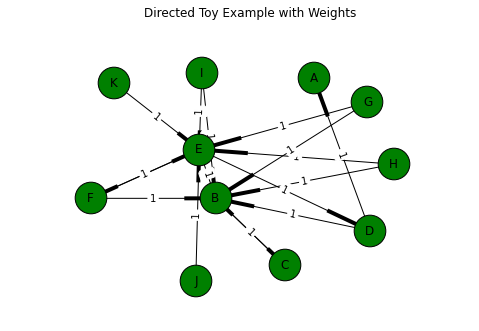

[0] Page Ranks: {'A': 0.09090909090909091, 'C': 0.09090909090909091, 'B': 0.09090909090909091, 'E': 0.09090909090909091, 'D': 0.09090909090909091, 'G': 0.09090909090909091, 'F': 0.09090909090909091, 'I': 0.09090909090909091, 'H': 0.09090909090909091, 'K': 0.09090909090909091, 'J': 0.09090909090909091}


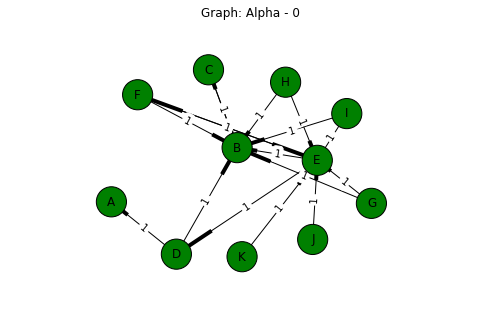

[0.15] Page Ranks: {'A': 0.08478337193849536, 'C': 0.09789412880777816, 'B': 0.12976602705087864, 'E': 0.12595852528732096, 'D': 0.08472680835862145, 'G': 0.07842886603965679, 'F': 0.08472680835862145, 'I': 0.07842886603965679, 'H': 0.07842886603965679, 'K': 0.07842886603965679, 'J': 0.07842886603965679}


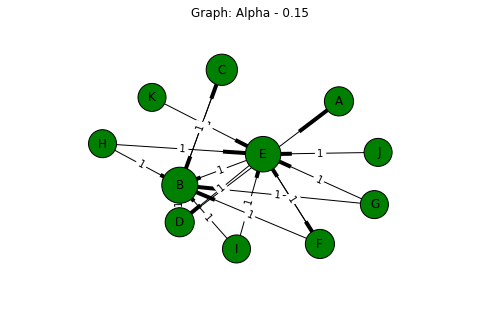

[0.25] Page Ranks: {'A': 0.0802296678675539, 'C': 0.10893861906184224, 'B': 0.15573019947246886, 'E': 0.1414842346470785, 'D': 0.08179558574699461, 'G': 0.07000522149141346, 'F': 0.08179558574699461, 'I': 0.07000522149141346, 'H': 0.07000522149141346, 'K': 0.07000522149141346, 'J': 0.07000522149141346}


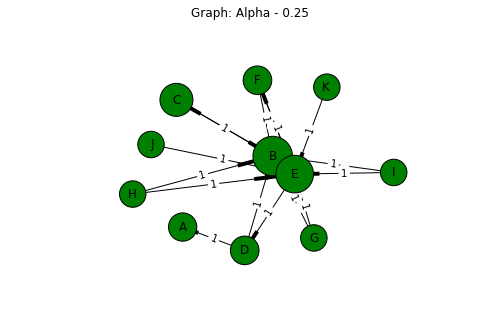

[0.5] Page Ranks: {'A': 0.06694781264624798, 'C': 0.1627142207497308, 'B': 0.22842968831839472, 'E': 0.1518186615813921, 'D': 0.07380073858214373, 'G': 0.048497627907989393, 'F': 0.07380073858214373, 'I': 0.048497627907989393, 'H': 0.048497627907989393, 'K': 0.048497627907989393, 'J': 0.048497627907989393}


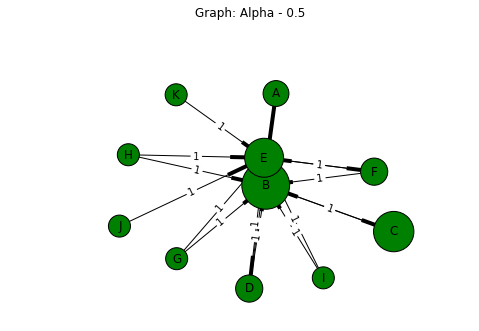

[0.75] Page Ranks: {'A': 0.046301461564296646, 'C': 0.2724191993634685, 'B': 0.32871881246243706, 'E': 0.11424746178750639, 'D': 0.05444605600812519, 'G': 0.025884190561208224, 'F': 0.05444605600812519, 'I': 0.025884190561208224, 'H': 0.025884190561208224, 'K': 0.025884190561208224, 'J': 0.025884190561208224}


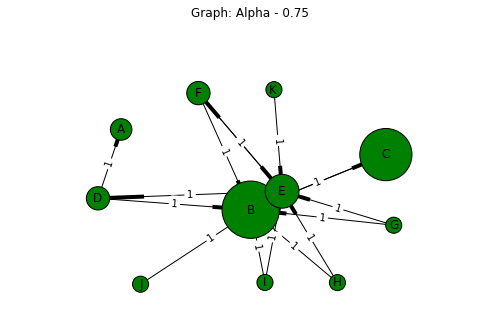

In [152]:
import networkx as nx
import ast
import matplotlib.pyplot as plt
%matplotlib inline

# Flexible Load Data Function
def load_data(filename):
    nodes = set()
    edges = set()
    with open (filename, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                edges.add((node, k, node_neighbors[k]))
                if k not in nodes:
                    nodes.add(k)
    return nodes, edges

def plot_graph(G, title, node_size=1000):
    # Plot network 
    pos=nx.spring_layout(G, k=0.95)
    nx.draw(G,pos, with_labels = True, node_color='g', node_size=node_size)
    # Specifiy Edge Labels
    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    plt.title(title)
    plt.show()

nodes, edges = load_data('./PageRank-test.txt')

# Plot Directed Graph
G=nx.DiGraph()

# Load into networkx
for node in nodes:
    G.add_node(node)    
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

plot_graph(G, title="Directed Toy Example with Weights")

NODE_SIZE = 10000
#alpha = [0,0.25,0.5,0.75,1]
alpha = [0,0.15,0.25,0.5,0.75]
for a in alpha:
    pr = nx.pagerank(G, alpha=a)
    print '[{0}] Page Ranks: {1}'.format(a, pr)
    node_size =[NODE_SIZE * v for v in pr.values()]
    #print '[{0}] Node Sizes: {1}\n'.format(a, node_size)
    plot_graph(G, node_size=node_size, title='Graph: Alpha - {0}'.format(a))
        
    